In [ ]:
# !nvidia-smi

In [1]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [2]:
torch.cuda.amp.autocast(enabled=True)

In [3]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer
from transformations import train_transforms,test_transforms

In [4]:
# ALbumentation

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.HorizontalFlip(always_apply=False,p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, mask_value=(0.4914, 0.4822, 0.4465), always_apply=False,p=0.5,),
    A.CoarseDropout( max_holes= 2,max_height = 8,max_width = 8,min_holes= 2,min_height = 8,min_width= 8,mask_fill_value = (0.4914, 0.4822, 0.4465),always_apply = False, p= 0.7),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616),p=1),
    ToTensorV2(),
])


atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)

In [5]:
# GET Train Loader
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

In [48]:
class DepthwiseConvLayer(nn.Module):
    def __init__(self,inc,outc,s,p,dp_rate)->None:
        super(DepthwiseConvLayer,self).__init__()
        self.c1 = nn.Conv2d(in_channels=inc,out_channels=inc,groups=inc,kernel_size=3,stride=s,padding=0,bias=False)
        nn.init.kaiming_uniform_(self.c1.weight, mode='fan_in', nonlinearity='relu')
        
        self.c2 = nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=1,padding=p,bias=False)
        nn.init.kaiming_uniform_(self.c2.weight, mode='fan_in', nonlinearity='relu')
        
        self.layer = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(outc),
            nn.Dropout2d(dp_rate)
        )
    def forward(self,x):
        x = self.c1(x)
        x = self.c2(x)
        return self.layer(x)

In [42]:
class Network2(nn.Module):
    def __init__(self,dp=0.1):
        super(Network2,self).__init__()
        self.dp = dp
        self.c1 = ConvLayer(inc=3, outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c2 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c3 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=2,dp_rate=self.dp)
        self.t1 = TransBlock(inc=16,outc=8,p=0)

        self.c4 = ConvLayer(inc=8,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c5 = ConvLayer(inc=32,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c6 = ConvLayer(inc=32,outc=32,k=3,p=0,s=1,d=4,dp_rate=self.dp)
        self.t2 = TransBlock(inc=32,outc=24,p=0)

        self.c7 = ConvLayer(inc=24,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c8 = ConvLayer(inc=40,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c9 = ConvLayer(inc=40,outc=40,k=3,p=0,s=2,d=4,dp_rate=self.dp)
        self.t3 = TransBlock(inc=40,outc=32,p=0)
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Sequential(TransBlock(inc=32,outc=10,p=0))
        
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        x = self.t1(x)
        
        x = self.c4(x)
        x = x + self.c5(x)
        x = self.c6(x)
        x = self.t2(x)
        
        x = self.c7(x)
        x = x + self.c8(x)
        # print(x.shape)
        
        x = self.c9(x)
        # print(x.shape)
        x = self.t3(x)
        
        x = self.gap(x)
        x = self.out(x)        
        return F.log_softmax(x.view(-1,10), dim=1)

In [37]:
layer = nn.Conv2d(in_channels=40,out_channels=40,kernel_size=3,dilation=4,stride=2,padding=0)
layer(torch.rand((1,40,22,22))).shape

torch.Size([1, 40, 7, 7])

In [43]:
model = Network2(dp=0.15).to(device)
summary(model,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Network2                                 [1, 10]                   --
├─ConvLayer: 1-1                         [1, 16, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-3                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 16, 32, 32]           --
├─ConvLayer: 1-2                         [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-6             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-8               [1, 16, 32, 32]           --
├─ConvLayer

In [44]:
# prev_test_loss = float('inf')

optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3,verbose=True)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    # if prev_test_loss>test_loss:
    #     torch.save(obj=model.state_dict(),f='./bmodels/model.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.88 | Batch = 97 | Accuracy = 25.35: 100%|███| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0033, Accuracy: 3710/10000 (37.10%)


EPOCH = 2 | LR = 0.1 | Loss = 1.57 | Batch = 97 | Accuracy = 36.16: 100%|███| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 0.0031, Accuracy: 4324/10000 (43.24%)


EPOCH = 3 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 40.96: 100%|███| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0029, Accuracy: 4595/10000 (45.95%)


EPOCH = 4 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 44.62: 100%|███| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0026, Accuracy: 5255/10000 (52.55%)


EPOCH = 5 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 48.38: 100%|███| 98/98 [00:35<00:00,  2.72it/s]


Test set: Average loss: 0.0025, Accuracy: 5640/10000 (56.40%)


EPOCH = 6 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 51.51: 100%|███| 98/98 [00:35<00:00,  2.73it/s]


Test set: Average loss: 0.0023, Accuracy: 5891/10000 (58.91%)


EPOCH = 7 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 53.44: 100%|███| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0022, Accuracy: 6023/10000 (60.23%)


EPOCH = 8 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 55.25: 100%|███| 98/98 [00:35<00:00,  2.73it/s]


Test set: Average loss: 0.0021, Accuracy: 6365/10000 (63.65%)


EPOCH = 9 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 57.14: 100%|███| 98/98 [00:35<00:00,  2.73it/s]


Test set: Average loss: 0.0021, Accuracy: 6201/10000 (62.01%)


EPOCH = 10 | LR = 0.1 | Loss = 1.08 | Batch = 97 | Accuracy = 58.90: 100%|██| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0019, Accuracy: 6551/10000 (65.51%)


EPOCH = 11 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 60.18: 100%|██| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6737/10000 (67.37%)


EPOCH = 12 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 61.41: 100%|██| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0018, Accuracy: 6852/10000 (68.52%)


EPOCH = 13 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 62.32: 100%|██| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0017, Accuracy: 6938/10000 (69.38%)


EPOCH = 14 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 63.28: 100%|██| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0018, Accuracy: 6760/10000 (67.60%)


EPOCH = 15 | LR = 0.1 | Loss = 0.99 | Batch = 97 | Accuracy = 64.08: 100%|██| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0019, Accuracy: 6746/10000 (67.46%)


EPOCH = 16 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 65.05: 100%|██| 98/98 [00:36<00:00,  2.72it/s]


Test set: Average loss: 0.0017, Accuracy: 7006/10000 (70.06%)


EPOCH = 17 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 65.40: 100%|██| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0016, Accuracy: 7189/10000 (71.89%)


EPOCH = 18 | LR = 0.1 | Loss = 0.91 | Batch = 97 | Accuracy = 66.08: 100%|██| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.0017, Accuracy: 7121/10000 (71.21%)


EPOCH = 19 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 67.01: 100%|██| 98/98 [00:36<00:00,  2.72it/s]


Test set: Average loss: 0.0016, Accuracy: 7280/10000 (72.80%)


EPOCH = 20 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 67.04: 100%|██| 98/98 [00:35<00:00,  2.76it/s]


Test set: Average loss: 0.0016, Accuracy: 7222/10000 (72.22%)


EPOCH = 21 | LR = 0.1 | Loss = 0.93 | Batch = 97 | Accuracy = 67.42: 100%|██| 98/98 [00:35<00:00,  2.76it/s]


Test set: Average loss: 0.0016, Accuracy: 7139/10000 (71.39%)


  0%|                                                                                | 0/98 [00:15<?, ?it/s]

KeyboardInterrupt



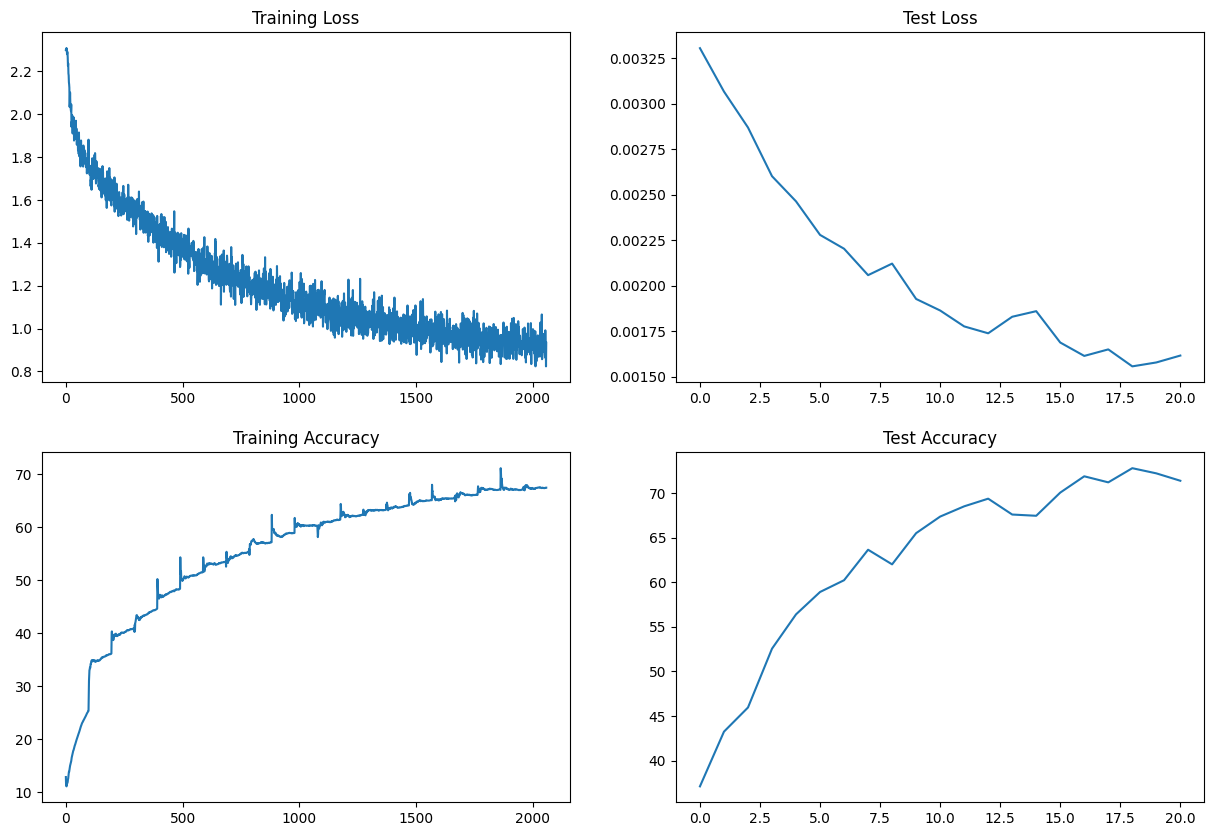

In [45]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [50]:
class Network(nn.Module):
    def __init__(self,dp=0.1):
        super(Network,self).__init__()
        self.dp = dp
        self.c1 = ConvLayer(inc=3, outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c2 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c2_add = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c3 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=2,dp_rate=self.dp)
        self.t1 = TransBlock(inc=16,outc=8,p=0)

        self.d1 = DepthwiseConvLayer(inc=8,outc=32,s=1,p=1,dp_rate=self.dp)
        self.c4 = ConvLayer(inc=32,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.d2 = DepthwiseConvLayer(inc=32,outc=32,s=1,p=1,dp_rate=self.dp)
        self.c5 = ConvLayer(inc=32,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c6 = ConvLayer(inc=32,outc=32,k=3,p=0,s=1,d=4,dp_rate=self.dp)
        self.t2 = TransBlock(inc=32,outc=24,p=0)

        self.d3 = DepthwiseConvLayer(inc=24,outc=40,s=1,p=1,dp_rate=self.dp)
        self.c7 = ConvLayer(inc=40,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.d4 = DepthwiseConvLayer(inc=40,outc=40,s=1,p=1,dp_rate=self.dp)
        self.c8 = ConvLayer(inc=40,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c9 = ConvLayer(inc=40,outc=80,k=3,p=0,s=2,d=6,dp_rate=self.dp)
        self.t3 = TransBlock(inc=80,outc=32,p=0)
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Sequential(TransBlock(inc=32,outc=10,p=0))
        
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = x + self.c2_add(x)
        x = self.c3(x)
        x = self.t1(x)

        x = self.d1(x)
        x = x + self.c4(x)
        x = x + self.d2(x)
        x = x + self.c5(x)
        x = self.c6(x)
        x = self.t2(x)

        x = self.d3(x)
        x = x + self.c7(x)
        x = x + self.d4(x)
        x = x + self.c8(x)
        x = self.c9(x)
        x = self.t3(x)
        
        x = self.gap(x)
        x = self.out(x)        
        return F.log_softmax(x.view(-1,10), dim=1)

In [51]:
m1 = Network().to(device)
summary(m1,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 10]                   --
├─ConvLayer: 1-1                         [1, 16, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-3                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 16, 32, 32]           --
├─ConvLayer: 1-2                         [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-6             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-8               [1, 16, 32, 32]           --
├─ConvLayer

In [52]:
# prev_test_loss = float('inf')

optimizer = optim.SGD(params=m1.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3,verbose=True)
criterion = nn.NLLLoss()
trainer = Trainer(model=m1, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=m1, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    # if prev_test_loss>test_loss:
    #     torch.save(obj=model.state_dict(),f='./bmodels/model.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.63 | Batch = 97 | Accuracy = 30.25: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0031, Accuracy: 4222/10000 (42.22%)


EPOCH = 2 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 42.28: 100%|███| 98/98 [00:42<00:00,  2.28it/s]


Test set: Average loss: 0.0028, Accuracy: 4762/10000 (47.62%)


EPOCH = 3 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 47.85: 100%|███| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0025, Accuracy: 5354/10000 (53.54%)


EPOCH = 4 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 52.21: 100%|███| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0023, Accuracy: 5899/10000 (58.99%)


EPOCH = 5 | LR = 0.1 | Loss = 1.16 | Batch = 97 | Accuracy = 55.57: 100%|███| 98/98 [00:43<00:00,  2.28it/s]


Test set: Average loss: 0.0021, Accuracy: 6205/10000 (62.05%)


EPOCH = 6 | LR = 0.1 | Loss = 1.15 | Batch = 97 | Accuracy = 58.75: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0021, Accuracy: 6280/10000 (62.80%)


EPOCH = 7 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 61.18: 100%|███| 98/98 [00:42<00:00,  2.28it/s]


Test set: Average loss: 0.0019, Accuracy: 6627/10000 (66.27%)


EPOCH = 8 | LR = 0.1 | Loss = 1.02 | Batch = 97 | Accuracy = 63.28: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0018, Accuracy: 6877/10000 (68.77%)


EPOCH = 9 | LR = 0.1 | Loss = 0.92 | Batch = 97 | Accuracy = 65.31: 100%|███| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0018, Accuracy: 6900/10000 (69.00%)


EPOCH = 10 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 66.60: 100%|██| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.0016, Accuracy: 7101/10000 (71.01%)


EPOCH = 11 | LR = 0.1 | Loss = 0.90 | Batch = 97 | Accuracy = 67.88: 100%|██| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0016, Accuracy: 7224/10000 (72.24%)


EPOCH = 12 | LR = 0.1 | Loss = 0.78 | Batch = 97 | Accuracy = 69.20: 100%|██| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0015, Accuracy: 7284/10000 (72.84%)


EPOCH = 13 | LR = 0.1 | Loss = 0.91 | Batch = 97 | Accuracy = 70.06: 100%|██| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0015, Accuracy: 7434/10000 (74.34%)


EPOCH = 14 | LR = 0.1 | Loss = 0.73 | Batch = 97 | Accuracy = 70.76: 100%|██| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0015, Accuracy: 7369/10000 (73.69%)


EPOCH = 15 | LR = 0.1 | Loss = 0.67 | Batch = 97 | Accuracy = 71.73: 100%|██| 98/98 [00:43<00:00,  2.23it/s]


Test set: Average loss: 0.0014, Accuracy: 7499/10000 (74.99%)


EPOCH = 16 | LR = 0.1 | Loss = 0.72 | Batch = 97 | Accuracy = 72.19: 100%|██| 98/98 [00:42<00:00,  2.28it/s]


Test set: Average loss: 0.0014, Accuracy: 7526/10000 (75.26%)


EPOCH = 17 | LR = 0.1 | Loss = 0.81 | Batch = 97 | Accuracy = 72.84: 100%|██| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0014, Accuracy: 7608/10000 (76.08%)


EPOCH = 18 | LR = 0.1 | Loss = 0.79 | Batch = 97 | Accuracy = 73.62: 100%|██| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0014, Accuracy: 7597/10000 (75.97%)


EPOCH = 19 | LR = 0.1 | Loss = 0.80 | Batch = 97 | Accuracy = 73.74: 100%|██| 98/98 [00:42<00:00,  2.28it/s]


Test set: Average loss: 0.0014, Accuracy: 7612/10000 (76.12%)


EPOCH = 20 | LR = 0.1 | Loss = 0.70 | Batch = 97 | Accuracy = 74.33: 100%|██| 98/98 [00:43<00:00,  2.25it/s]


Test set: Average loss: 0.0013, Accuracy: 7718/10000 (77.18%)


EPOCH = 21 | LR = 0.1 | Loss = 0.75 | Batch = 97 | Accuracy = 74.84: 100%|██| 98/98 [00:43<00:00,  2.23it/s]


Test set: Average loss: 0.0013, Accuracy: 7761/10000 (77.61%)


EPOCH = 22 | LR = 0.1 | Loss = 0.65 | Batch = 97 | Accuracy = 75.02: 100%|██| 98/98 [00:43<00:00,  2.27it/s]


Test set: Average loss: 0.0013, Accuracy: 7771/10000 (77.71%)


EPOCH = 23 | LR = 0.1 | Loss = 0.74 | Batch = 97 | Accuracy = 75.28: 100%|██| 98/98 [00:43<00:00,  2.28it/s]


Test set: Average loss: 0.0013, Accuracy: 7794/10000 (77.94%)


EPOCH = 24 | LR = 0.1 | Loss = 0.79 | Batch = 97 | Accuracy = 76.19: 100%|██| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.0013, Accuracy: 7800/10000 (78.00%)


EPOCH = 25 | LR = 0.1 | Loss = 0.68 | Batch = 97 | Accuracy = 76.17: 100%|██| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0013, Accuracy: 7791/10000 (77.91%)


EPOCH = 26 | LR = 0.1 | Loss = 0.67 | Batch = 97 | Accuracy = 76.57: 100%|██| 98/98 [00:42<00:00,  2.28it/s]


Test set: Average loss: 0.0013, Accuracy: 7801/10000 (78.01%)


EPOCH = 27 | LR = 0.1 | Loss = 0.55 | Batch = 97 | Accuracy = 76.80: 100%|██| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0013, Accuracy: 7768/10000 (77.68%)


EPOCH = 28 | LR = 0.1 | Loss = 0.64 | Batch = 97 | Accuracy = 76.71: 100%|██| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0013, Accuracy: 7773/10000 (77.73%)


EPOCH = 29 | LR = 0.1 | Loss = 0.61 | Batch = 97 | Accuracy = 77.28: 100%|██| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0013, Accuracy: 7843/10000 (78.43%)


EPOCH = 30 | LR = 0.1 | Loss = 0.62 | Batch = 97 | Accuracy = 77.63: 100%|██| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.0012, Accuracy: 7852/10000 (78.52%)


EPOCH = 31 | LR = 0.1 | Loss = 0.60 | Batch = 97 | Accuracy = 77.60: 100%|██| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.0012, Accuracy: 7859/10000 (78.59%)


EPOCH = 32 | LR = 0.1 | Loss = 0.64 | Batch = 97 | Accuracy = 77.95: 100%|██| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.0012, Accuracy: 7853/10000 (78.53%)


  0%|                                                                                | 0/98 [00:13<?, ?it/s]

KeyboardInterrupt



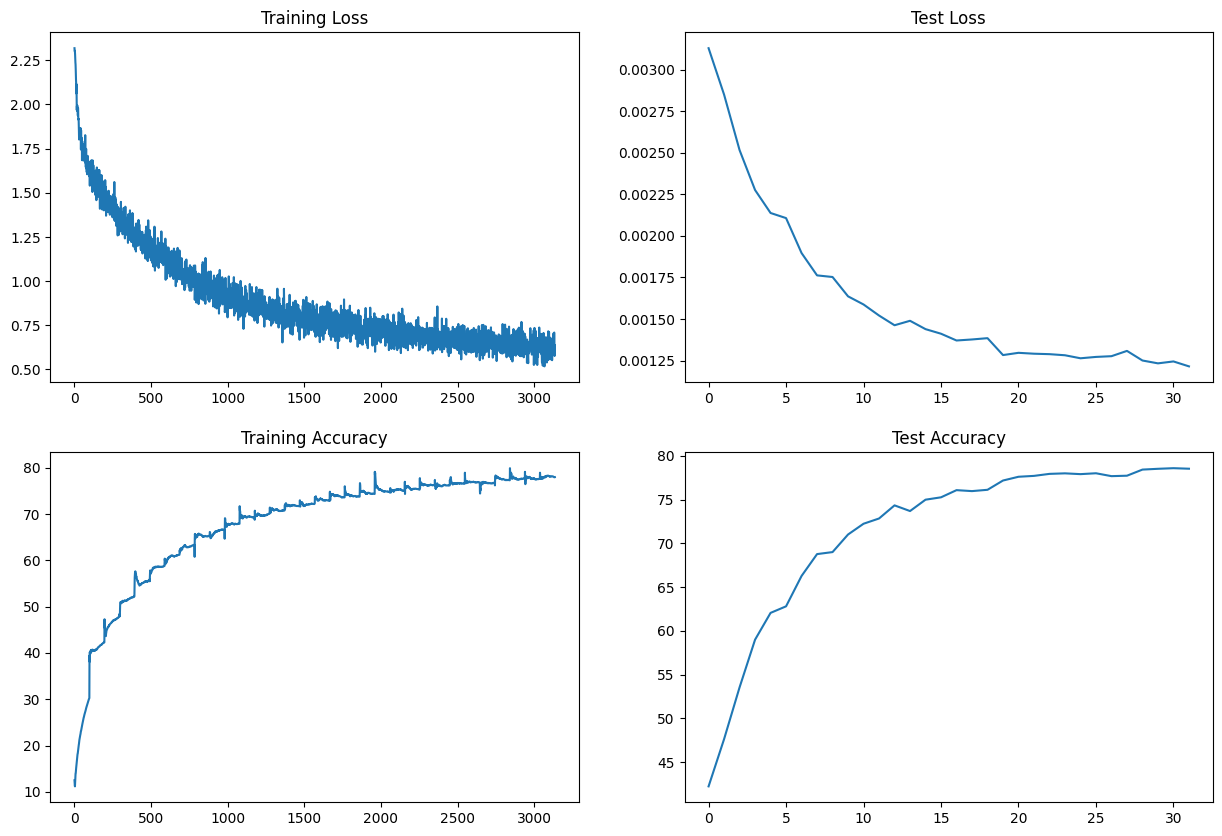

In [53]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [24]:
class Network2(nn.Module):
    def __init__(self,squeeze_channels,dp=0.1):
        super(Network2,self).__init__()
        self.dp = dp
        self.c1 = ConvLayer(inc=squeeze_channels[0], outc=squeeze_channels[2],k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c2 = ConvLayer(inc=squeeze_channels[2],outc=squeeze_channels[2],k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c3 = ConvLayer(inc=squeeze_channels[2],outc=squeeze_channels[2],k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c4 = ConvLayer(inc=squeeze_channels[2],outc=squeeze_channels[2],k=3,p=1,s=1,d=2,dp_rate=self.dp)
        self.t1 = TransBlock(inc=squeeze_channels[2],outc=squeeze_channels[1],p=0)

        self.d1 = DepthwiseConvLayer(inc=squeeze_channels[1],outc=squeeze_channels[4],s=1,p=1,dp_rate=self.dp)
        self.c5 = ConvLayer(inc=squeeze_channels[4],outc=squeeze_channels[4],k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.d2 = DepthwiseConvLayer(inc=squeeze_channels[4],outc=squeeze_channels[4],s=1,p=1,dp_rate=self.dp)
        self.c6 = ConvLayer(inc=squeeze_channels[4],outc=squeeze_channels[4],k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c7 = ConvLayer(inc=squeeze_channels[4],outc=squeeze_channels[4],k=3,p=0,s=1,d=4,dp_rate=self.dp)
        self.t2 = TransBlock(inc=squeeze_channels[4],outc=squeeze_channels[3],p=0)

        self.d3 = DepthwiseConvLayer(inc=squeeze_channels[3],outc=squeeze_channels[5],s=1,p=1,dp_rate=self.dp)
        self.c8 = ConvLayer(inc=squeeze_channels[5],outc=squeeze_channels[5],k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.d4 = DepthwiseConvLayer(inc=squeeze_channels[5],outc=squeeze_channels[5],s=1,p=1,dp_rate=self.dp)
        self.c9 = ConvLayer(inc=squeeze_channels[5],outc=squeeze_channels[5],k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c10 = ConvLayer(inc=squeeze_channels[5],outc=squeeze_channels[6],k=3,p=0,s=1,d=8,dp_rate=self.dp)
        self.t3 = TransBlock(inc=squeeze_channels[6],outc=squeeze_channels[3],p=0)
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Sequential(TransBlock(inc=squeeze_channels[3],outc=10,p=0))
        
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = x + self.c3(x)
        x = self.c4(x)
        x = self.t1(x)

        x = self.d1(x)
        x = x + self.c5(x)
        x = x + self.d2(x)
        x = x + self.c6(x)
        x = self.c7(x)
        x = self.t2(x)

        x = self.d3(x)
        x = x + self.c8(x)
        x = x + self.d4(x)
        x = x + self.c9(x)
        x = self.c10(x)
        x = self.t3(x)
        
        x = self.gap(x)
        x = self.out(x)        
        return F.log_softmax(x.view(-1,10), dim=1)

In [25]:
m2 = Network2(squeeze_channels=[3,16,24,30,34,44,50],dp=0.15)
summary(m2,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Network2                                 [1, 10]                   --
├─ConvLayer: 1-1                         [1, 24, 32, 32]           --
│    └─Sequential: 2-1                   [1, 24, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 24, 32, 32]           648
│    │    └─BatchNorm2d: 3-2             [1, 24, 32, 32]           48
│    │    └─ReLU: 3-3                    [1, 24, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 24, 32, 32]           --
├─ConvLayer: 1-2                         [1, 24, 32, 32]           --
│    └─Sequential: 2-2                   [1, 24, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 24, 32, 32]           5,184
│    │    └─BatchNorm2d: 3-6             [1, 24, 32, 32]           48
│    │    └─ReLU: 3-7                    [1, 24, 32, 32]           --
│    │    └─Dropout2d: 3-8               [1, 24, 32, 32]           --
├─ConvLayer

In [27]:
# prev_test_loss = float('inf')

optimizer = optim.SGD(params=m2.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3,verbose=True)
criterion = nn.NLLLoss()
trainer = Trainer(model=m2, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=m2, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    # if prev_test_loss>test_loss:
    #     torch.save(obj=model.state_dict(),f='./bmodels/model.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.85 | Batch = 97 | Accuracy = 25.88: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0033, Accuracy: 3864/10000 (38.64%)


EPOCH = 2 | LR = 0.1 | Loss = 1.72 | Batch = 97 | Accuracy = 35.85: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0030, Accuracy: 4445/10000 (44.45%)


EPOCH = 3 | LR = 0.1 | Loss = 1.76 | Batch = 97 | Accuracy = 39.38: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0029, Accuracy: 4702/10000 (47.02%)


EPOCH = 4 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 41.52: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0027, Accuracy: 5016/10000 (50.16%)


EPOCH = 5 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 43.45: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0026, Accuracy: 5206/10000 (52.06%)


EPOCH = 6 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 45.02: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0025, Accuracy: 5374/10000 (53.74%)


EPOCH = 7 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 46.56: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0024, Accuracy: 5521/10000 (55.21%)


EPOCH = 8 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 47.63: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0024, Accuracy: 5614/10000 (56.14%)


EPOCH = 9 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 48.61: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0023, Accuracy: 5781/10000 (57.81%)


  0%|                                                                                                                                             | 0/98 [00:20<?, ?it/s]

KeyboardInterrupt



In [7]:
# backup best model

class Network(nn.Module):
    def __init__(self,dp=0.1):
        super(Network,self).__init__()
        self.dp = dp
        self.c1 = ConvLayer(inc=3, outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c2 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c3 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=2,dp_rate=self.dp)
        self.t1 = TransBlock(inc=16,outc=8,p=0)

        self.c4 = ConvLayer(inc=8,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c5 = ConvLayer(inc=32,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c6 = ConvLayer(inc=32,outc=32,k=3,p=0,s=1,d=4,dp_rate=self.dp)
        self.t2 = TransBlock(inc=32,outc=24,p=0)

        self.c7 = ConvLayer(inc=24,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c8 = ConvLayer(inc=40,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c9 = ConvLayer(inc=40,outc=40,k=3,p=0,s=1,d=8,dp_rate=self.dp)
        self.t3 = TransBlock(inc=40,outc=32,p=0)
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Sequential(TransBlock(inc=32,outc=10,p=0))
        
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        x = self.t1(x)
        
        x = self.c4(x)
        x = x + self.c5(x)
        x = self.c6(x)
        x = self.t2(x)
        
        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)
        x = self.t3(x)
        
        x = self.gap(x)
        x = self.out(x)        
        return F.log_softmax(x.view(-1,10), dim=1)